# Evaluando prosibles Modelos No supervisados para El proyecto de Contugas

En este proyecto estamos trabajando en la detección de anomalías usando aprendizaje no supervisado.Se decidió utilizar Isolation Forest y DBSCAN porque no contamos con etiquetas reales de anomalías.
Los modelos no requieren etiquetas para entrenar, pero para tener una idea de su desempeño,vamos a crear unas etiquetas proxy basadas en los percentiles 10 y 90 de las variables de interés.Estas etiquetas proxy no se usan para entrenar los modelos, solamente para hacer una evaluación inicial de métricas como Precision, Recall y F1 Score.
El objetivo es que el modelo identifique patrones anómalos de forma automática y que podamos validar, de forma técnica, que las detecciones son razonables.
Además, para DBSCAN evaluaremos el Silhouette Score para asegurarnos de que los clusters estén bien separados.A futuro, cuando el modelo se use en la vida real, no se necesitarán las etiquetas proxy, ya que Isolation Forest y DBSCAN funcionan de forma no supervisada.


## Probando mas modelos

Probar un procedimiento para agrupamiento por clientes
## Para Modelos entrenados por cliente I

Con el objetivo de construir modelos más precisos para la detección de anomalías que consideren las diferencias en los patrones de consumo de cada cliente, se plantea un enfoque basado en la **agrupación de clientes según similitud de comportamiento**.

### 1. Representación del comportamiento por cliente  
Se utiliza la **media y la desviación estándar** de las variables de **presión, volumen y temperatura** como indicadores representativos del comportamiento de cada cliente.

### 2. Evaluación de la agrupación  
En esta etapa exploratoria se busca determinar si la segmentación de clientes es adecuada mediante:
- El cálculo del **coeficiente de silueta (Silhouette Score)**, que mide la cohesión y separación entre grupos.
- La **visualización de los clusters** proyectados en dos dimensiones mediante Análisis de Componentes Principales (PCA), para evaluar su separación visual.

### 3. Preparación para integración en pipeline  
se creará una funcion para que, al ingresar datos de nuevos registros identificados por cliente, el sistema asigne automáticamente su **grupo de comportamiento** y redirija los datos al **modelo de detección de anomalías específico** para ese grupo.


# Agrupación por Mediana/IQR

In [10]:
# =============================================================================
# --- Sección 1: Configuraciones e Imports ---
# =============================================================================
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, precision_score, recall_score, f1_score
import warnings
import traceback # Importar traceback para detalles de error

# Imports para Visualización
import matplotlib.pyplot as plt
import seaborn as sns # Para un estilo más agradable (opcional)

# Configurar estilo de Seaborn (opcional)
sns.set_theme(style="whitegrid")


# Ignorar warnings específicos (opcional)
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn.utils.deprecation')
warnings.filterwarnings("ignore", message="Downcasting object dtype arrays on .fillna")
# Ignorar avisos comuns em métricas com classes únicas ou divisões por zero na avaliação
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# --- Configuraciones Generales ---
ARCHIVO_DATOS = 'df_con_anomalias.csv' # !! VERIFIQUE ESTA RUTA !!
DIRECTORIO_SALIDA_MODELOS = 'modelos_kmeans5_dinamico_otimizado_viz_otim_sem_hist' # Directorio específico
ESTADO_ALEATORIO = 42 # Para reproducibilidad
FEATURES_ANOMALIA = ['Presion', 'Temperatura', 'Volumen'] # Features para detección
SUFIJO_MODELO = "_kmeans5_dinamico_otimizado_viz_otim_sem_hist" # Sufijo para modelos guardados
N_CLUSTERS = 5 # Número fijo de clusters para KMeans
# ARCHIVO_GRAFICO_METRICAS eliminado porque el gráfico fue eliminado
# Configs para gráfico de dispersión (Sección 9)
FEATURE_X_VIZ = 'Volumen'
FEATURE_Y_VIZ = 'Presion'


# Crear directorio de salida si no existe
os.makedirs(DIRECTORIO_SALIDA_MODELOS, exist_ok=True)

print(">>> INICIO: Script Completo (KMeans(5) + IForest Dinámico + Evaluación Optimizada + Viz Optimizada - SIN Gráfico Barras) <<<")
print(f"Usando directorio de salida: {DIRECTORIO_SALIDA_MODELOS}")
print(f"Usando sufijo de modelo: {SUFIJO_MODELO}")
print(f"Número de clusters (KMeans): {N_CLUSTERS}")

>>> INICIO: Script Completo (KMeans(5) + IForest Dinámico + Evaluación Optimizada + Viz Optimizada - SIN Gráfico Barras) <<<
Usando directorio de salida: modelos_kmeans5_dinamico_otimizado_viz_otim_sem_hist
Usando sufijo de modelo: _kmeans5_dinamico_otimizado_viz_otim_sem_hist
Número de clusters (KMeans): 5


In [11]:
# =============================================================================
# --- Sección 2: Carga de Datos ---
# =============================================================================
print("\n--- 1. Carga de Datos ---")
df = None # Inicializar variable
try:
    df = pd.read_csv(ARCHIVO_DATOS)
    print(f"Datos cargados de '{ARCHIVO_DATOS}'. Shape: {df.shape}")
    columnas_requeridas = FEATURES_ANOMALIA + ['Cliente']
    if not all(f in df.columns for f in columnas_requeridas): raise ValueError(f"Faltan columnas requeridas ({columnas_requeridas})")
    for col in FEATURES_ANOMALIA: df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=FEATURES_ANOMALIA, inplace=True)
    print("Columnas features convertidas a numérico y NaNs eliminados.")
    # print("Primeras 5 filas del DataFrame:"); print(df.head()) # Descomentar si es necesario
except FileNotFoundError: print(f"ERROR CRÍTICO: Archivo '{ARCHIVO_DATOS}' no encontrado."); exit()
except ValueError as e: print(f"ERROR CRÍTICO: Problema con las columnas: {e}"); exit()
except Exception as e: print(f"Error inesperado al cargar datos: {e}"); traceback.print_exc(); exit()
if df is None or df.empty: print("Error crítico: DataFrame 'df' no cargado o vacío."); exit()
else: print("Carga de datos completada con éxito.")


--- 1. Carga de Datos ---
Datos cargados de 'df_con_anomalias.csv'. Shape: (847960, 9)
Columnas features convertidas a numérico y NaNs eliminados.
Carga de datos completada con éxito.


In [30]:
# =============================================================================
# --- Sección 3: Agregación por Cliente (Median/IQR) ---
# =============================================================================

print("\n--- 2. Agregación por Cliente (Median/IQR) ---")
print("Calculando estadísticas Median/IQR por cliente ('resumen')...")

def iqr(x):
    """Función auxiliar para calcular el Rango Intercuartílico (IQR)."""
    return x.quantile(0.75) - x.quantile(0.25)

# Features sobre las que calcular estadísticas
features_para_estadisticas_agg = FEATURES_ANOMALIA
resumen = None # Inicializar variable

try:
    # Agrupar por 'Cliente' y calcular mediana e IQR para las features especificadas
    resumen = df.groupby('Cliente')[features_para_estadisticas_agg].agg(['median', iqr])
    # Renombrar las columnas resultantes para que sean más claras (ej: 'Presion_median', 'Presion_iqr')
    resumen.columns = ['_'.join(col).strip() for col in resumen.columns.values]
    # Rellenar posibles valores NaN con 0 (pueden ocurrir si un grupo tiene solo 1 observación)
    resumen = resumen.fillna(0)
    print(f"'resumen' (Median/IQR) creado. Shape: {resumen.shape}")
    print("Primeras 5 filas del Resumen:")
    print(resumen.head())

except Exception as e:
     # Capturar cualquier error durante la agregación
     print(f"Error al crear 'resumen' con Median/IQR: {e}")
     exit() # Salir si la agregación falla

# Verificar si el resumen se creó correctamente
if resumen is None or resumen.empty:
    print("Error crítico: DataFrame 'resumen' no pudo ser creado.")
    exit()
else:
    print("Agregación por cliente completada con éxito.")


--- 2. Agregación por Cliente (Median/IQR) ---
Calculando estadísticas Median/IQR por cliente ('resumen')...
'resumen' (Median/IQR) creado. Shape: (20, 6)
Primeras 5 filas del Resumen:
           Presion_median  Presion_iqr  Temperatura_median  Temperatura_iqr  \
Cliente                                                                       
CLIENTE1        17.651439     0.120326           25.711326         4.108541   
CLIENTE10       17.495303     0.143073           23.535509         4.274417   
CLIENTE11        3.535771     0.096534           26.198136         4.521384   
CLIENTE12       17.834866     0.567262           27.049023         8.926224   
CLIENTE13       17.511078     0.106789           21.570406         4.708313   

           Volumen_median  Volumen_iqr  
Cliente                                 
CLIENTE1        22.470213     9.284235  
CLIENTE10        0.000000     0.000000  
CLIENTE11      136.075518    44.966199  
CLIENTE12        0.000000    77.654802  
CLIENTE13     

In [13]:
# =============================================================================
# --- Sección 4: Clusterización de Clientes (KMeans) ---
# =============================================================================
print("\n--- 3. Clusterización de Clientes (KMeans) ---")
kmeans_model = None; escalador_resumen = None; X_resumen_escalado = None
mapa_cliente_a_cluster = {}
try:
    print("Escalando datos del 'resumen'...")
    X_resumen = resumen[resumen.columns]
    escalador_resumen = StandardScaler(); X_resumen_escalado = escalador_resumen.fit_transform(X_resumen)
    if np.isnan(X_resumen_escalado).any():
        from sklearn.impute import SimpleImputer; imputador = SimpleImputer(strategy='mean'); X_resumen_escalado = imputador.fit_transform(X_resumen_escalado)
    print(f"Shape de los datos del resumen escalados: {X_resumen_escalado.shape}")
    print(f"Aplicando KMeans (n_clusters={N_CLUSTERS})...")
    kmeans_model = KMeans(n_clusters=N_CLUSTERS, random_state=ESTADO_ALEATORIO, n_init=10); etiquetas_cluster = kmeans_model.fit_predict(X_resumen_escalado)
    resumen['cluster'] = etiquetas_cluster
    print("Distribución de clientes por cluster:"); print(pd.Series(etiquetas_cluster).value_counts().sort_index())
    if 'cluster' in resumen.columns:
        if 'Cliente' in resumen.index.names: mapa_cliente_a_cluster = resumen['cluster'].to_dict()
        else:
            try: mapa_cliente_a_cluster = resumen.reset_index().set_index('Cliente')['cluster'].to_dict()
            except: print("Advertencia: No se pudo crear mapa cliente->cluster.")
        print(f"Mapa cliente -> cluster creado ({len(mapa_cliente_a_cluster)} entradas).")
    if len(set(etiquetas_cluster)) > 1:
        try: silhouette_promedio = silhouette_score(X_resumen_escalado, etiquetas_cluster); print(f"Coeficiente de Silhouette medio: {silhouette_promedio:.3f}")
        except Exception as e: print(f"Error calculando Silhouette score: {e}")
    print("Guardando modelo KMeans y escalador del resumen...")
    ruta_kmeans = os.path.join(DIRECTORIO_SALIDA_MODELOS, f'kmeans_cliente_model{SUFIJO_MODELO}.joblib')
    ruta_scaler_resumen = os.path.join(DIRECTORIO_SALIDA_MODELOS, f'resumen_scaler{SUFIJO_MODELO}.joblib')
    joblib.dump(kmeans_model, ruta_kmeans); joblib.dump(escalador_resumen, ruta_scaler_resumen)
    print(f"Modelos guardados en: {DIRECTORIO_SALIDA_MODELOS}")
except Exception as e: print(f"Error durante la clusterización: {e}"); traceback.print_exc(); exit()
if 'cluster' not in resumen.columns: print("Error crítico: Columna 'cluster' no fue añadida a 'resumen'."); exit()
else: print("Clusterización de clientes completada con éxito.")


--- 3. Clusterización de Clientes (KMeans) ---
Escalando datos del 'resumen'...
Shape de los datos del resumen escalados: (20, 6)
Aplicando KMeans (n_clusters=5)...
Distribución de clientes por cluster:
0    4
1    7
2    2
3    2
4    5
Name: count, dtype: int64
Mapa cliente -> cluster creado (20 entradas).
Coeficiente de Silhouette medio: 0.518
Guardando modelo KMeans y escalador del resumen...
Modelos guardados en: modelos_kmeans5_dinamico_otimizado_viz_otim_sem_hist
Clusterización de clientes completada con éxito.


In [14]:
# =============================================================================
# --- Sección 5: Preparación para Entrenamiento (Asociación Clusters y Proxy) ---
# =============================================================================
print("\n--- 4. Preparación para Entrenamiento por Cluster ---")
df_clusterizado = None
try:
    print("Asociando registros de consumo a sus respectivos clusters...")
    if 'Cliente' in resumen.index.names: resumen_para_merge = resumen.reset_index()
    elif 'Cliente' in resumen.columns: resumen_para_merge = resumen
    else: resumen_para_merge = resumen.reset_index().rename(columns={'index':'Cliente'})
    if 'Cliente' not in resumen_para_merge.columns or 'cluster' not in resumen_para_merge.columns: raise ValueError("Columnas 'Cliente' o 'cluster' faltantes.")
    df_clusterizado = df.merge(resumen_para_merge[['Cliente', 'cluster']], on='Cliente', how='left')
    registros_antes = len(df_clusterizado); df_clusterizado.dropna(subset=['cluster'], inplace=True); registros_despues = len(df_clusterizado)
    if registros_antes > registros_despues: print(f"Advertencia: {registros_antes - registros_despues} registros eliminados por no tener cluster asociado.")
    df_clusterizado['cluster'] = df_clusterizado['cluster'].astype(int)
    print(f"Asociación de clusters completada. Shape df_clusterizado: {df_clusterizado.shape}")
    print("Calculando 'Anomalia_Proxy_Cluster' (usando P10/P90 dentro de cada cluster)...")
    df_clusterizado['Anomalia_Proxy_Cluster'] = pd.NA
    for k_proxy in range(N_CLUSTERS):
        idx = df_clusterizado.index[df_clusterizado['cluster'] == k_proxy]
        if idx.empty: continue
        df_k = df_clusterizado.loc[idx, FEATURES_ANOMALIA].copy()
        anom_k = pd.DataFrame(index=idx)
        for f in FEATURES_ANOMALIA:
            p10 = df_k[f].quantile(0.10); p90 = df_k[f].quantile(0.90)
            if pd.isna(p10) or pd.isna(p90) or p10 == p90: anom_k[f] = 0
            else: anom_k[f] = df_k[f].apply(lambda x: 1 if (x < p10) or (x > p90) else 0)
        df_clusterizado.loc[idx, 'Anomalia_Proxy_Cluster'] = anom_k.max(axis=1)
    df_clusterizado['Anomalia_Proxy_Cluster'] = df_clusterizado['Anomalia_Proxy_Cluster'].fillna(0).astype(int)
    print("Columna 'Anomalia_Proxy_Cluster' calculada y añadida a df_clusterizado.")
    # print("Distribución de Anomalia_Proxy_Cluster (0=Normal Proxy, 1=Anomalia Proxy):"); print(df_clusterizado['Anomalia_Proxy_Cluster'].value_counts()) # Descomentar si es necesario
except ValueError as e: print(f"Error de Valor durante la preparación/cálculo proxy: {e}"); exit()
except Exception as e: print(f"Error inesperado en preparación para entrenamiento: {e}"); traceback.print_exc(); exit()
if df_clusterizado is None or 'Anomalia_Proxy_Cluster' not in df_clusterizado.columns: print("Error crítico: 'df_clusterizado' o 'Anomalia_Proxy_Cluster' no fueron creados correctamente."); exit()
else: print("Preparación para entrenamiento completada con éxito.")


--- 4. Preparación para Entrenamiento por Cluster ---
Asociando registros de consumo a sus respectivos clusters...
Asociación de clusters completada. Shape df_clusterizado: (847960, 10)
Calculando 'Anomalia_Proxy_Cluster' (usando P10/P90 dentro de cada cluster)...
Columna 'Anomalia_Proxy_Cluster' calculada y añadida a df_clusterizado.
Preparación para entrenamiento completada con éxito.


In [21]:
# =============================================================================
# --- Sección 4.5: Estadísticas Descriptivas por Cluster ---
# =============================================================================
print("\n--- 4.5: Estadísticas Descriptivas por Cluster ---")

if 'df_clusterizado' in locals() and df_clusterizado is not None and not df_clusterizado.empty and 'cluster' in df_clusterizado.columns and 'FEATURES_ANOMALIA' in locals():
    print("Calculando estadísticas descriptivas de las features originales por cluster asignado...")

    try:
        # Usar groupby().describe() para obtener un resumen completo por cluster
        estadisticas_por_cluster = df_clusterizado.groupby('cluster')[FEATURES_ANOMALIA].describe()

        # Mostrar las estadísticas de forma más legible (como en el original)
        print("\nEstadísticas Descriptivas (describe()) para Features Originales por Cluster:")
        for feature in FEATURES_ANOMALIA:
            print(f"\n--- Estadísticas para '{feature}' ---")
            # Imprimir directamente la rebanada del describe para esa feature
            # Pandas generalmente formatea esto de manera horizontal por cluster
            print(estadisticas_por_cluster[feature]) # <<-- MUDANÇA AQUI
            print("-" * (len(feature) + 24)) # Separador

    except KeyError as e:
        print(f"ERROR: No se encontró la columna necesaria para las estadísticas: {e}")
    except Exception as e:
        print(f"Error inesperado al calcular/mostrar estadísticas descriptivas: {e}")
        traceback.print_exc()
else:
    print("Advertencia: No se pudo calcular estadísticas descriptivas (Verificar salida de Sección 4 y DEBUG).")

print("\nEstadísticas descriptivas por cluster finalizadas.")


--- 4.5: Estadísticas Descriptivas por Cluster ---
Calculando estadísticas descriptivas de las features originales por cluster asignado...

Estadísticas Descriptivas (describe()) para Features Originales por Cluster:

--- Estadísticas para 'Presion' ---
            count       mean       std        min        25%        50%  \
cluster                                                                   
0        171910.0  17.138132  0.648306  13.810026  16.536808  17.372461   
1        294999.0  17.532349  0.272378  14.489896  17.469962  17.558586   
2         84496.0   3.557552  0.082575   2.934873   3.500830   3.547267   
3         83552.0  17.662240  0.467150  13.740922  17.361668  17.658986   
4        213003.0  17.533407  0.340062  13.616877  17.582176  17.643291   

               75%        max  
cluster                        
0        17.718070  19.720870  
1        17.692895  20.112931  
2         3.603260   4.037030  
3        17.977491  20.307852  
4        17.689789  20.0283

In [25]:
# =============================================================================
# --- Sección 6: Entrenamiento por Cluster (IForest Dinámico) ---
# =============================================================================
print("\n--- 5. Entrenamiento por Cluster (IForest Dinámico) ---")
clusters_treinados_com_sucesso = []
if df_clusterizado is not None and 'Anomalia_Proxy_Cluster' in df_clusterizado.columns:
    print("Iniciando bucle de entrenamiento por cluster...")
    for k in range(N_CLUSTERS):
        print(f"--- Entrenando modelo para Cluster {k} ---")
        df_k = df_clusterizado[df_clusterizado['cluster'] == k].copy()
        if df_k.empty or df_k.shape[0] < 2: print(f"  Cluster {k} está vacío o tiene pocas muestras. Omitiendo."); continue
        X_k = df_k[FEATURES_ANOMALIA]; y_proxy_k = df_k['Anomalia_Proxy_Cluster']
        cont_k = 'auto'
        if y_proxy_k.nunique() > 1 and y_proxy_k.sum() > 0:
            r = y_proxy_k.mean(); cont_k = np.clip(r, 0.001, 0.499); print(f"  Proporción Proxy para Cluster {k}: {r:.3f} -> Contaminación: {cont_k:.3f}")
        elif y_proxy_k.sum() == 0: print(f"  Advertencia Cluster {k}: No hay anomalías proxy. Usando contamination='auto'")
        else: print(f"  Advertencia Cluster {k}: Solo una clase proxy. Usando contamination='auto'")
        try:
             sc_k = StandardScaler(); Xk_sc = sc_k.fit_transform(X_k)
             if_k = IsolationForest(contamination=cont_k, random_state=ESTADO_ALEATORIO); if_k.fit(Xk_sc)
             print(f"  Modelo Isolation Forest entrenado.")
        except Exception as e: print(f"  ERROR durante escalado/entrenamiento para cluster {k}: {e}"); continue
        ruta_sc = os.path.join(DIRECTORIO_SALIDA_MODELOS, f'scaler_cluster_{k}{SUFIJO_MODELO}.joblib')
        ruta_if = os.path.join(DIRECTORIO_SALIDA_MODELOS, f'iforest_cluster_{k}{SUFIJO_MODELO}.joblib')
        try: joblib.dump(sc_k, ruta_sc); joblib.dump(if_k, ruta_if); print(f"  Modelo y Escalador guardados en '{DIRECTORIO_SALIDA_MODELOS}'."); clusters_treinados_com_sucesso.append(k)
        except Exception as e: print(f"  ERROR al guardar modelo/escalador para cluster {k}: {e}")
else: print("ERROR: df_clusterizado o Anomalia_Proxy_Cluster no definidos. No se puede entrenar."); exit()
if not clusters_treinados_com_sucesso: print("--- Entrenamiento por cluster finalizado, pero NINGÚN modelo se guardó con éxito. ---")
else: print(f"--- Entrenamiento por cluster finalizado. Clusters entrenados con éxito: {sorted(clusters_treinados_com_sucesso)} ---")


--- 5. Entrenamiento por Cluster (IForest Dinámico) ---
Iniciando bucle de entrenamiento por cluster...
--- Entrenando modelo para Cluster 0 ---
  Proporción Proxy para Cluster 0: 0.436 -> Contaminación: 0.436
  Modelo Isolation Forest entrenado.
  Modelo y Escalador guardados en 'modelos_kmeans5_dinamico_otimizado_viz_otim_sem_hist'.
--- Entrenando modelo para Cluster 1 ---
  Proporción Proxy para Cluster 1: 0.411 -> Contaminación: 0.411
  Modelo Isolation Forest entrenado.
  Modelo y Escalador guardados en 'modelos_kmeans5_dinamico_otimizado_viz_otim_sem_hist'.
--- Entrenando modelo para Cluster 2 ---
  Proporción Proxy para Cluster 2: 0.461 -> Contaminación: 0.461
  Modelo Isolation Forest entrenado.
  Modelo y Escalador guardados en 'modelos_kmeans5_dinamico_otimizado_viz_otim_sem_hist'.
--- Entrenando modelo para Cluster 3 ---
  Proporción Proxy para Cluster 3: 0.414 -> Contaminación: 0.414
  Modelo Isolation Forest entrenado.
  Modelo y Escalador guardados en 'modelos_kmeans5_di

In [26]:
# =============================================================================
# --- Sección 7: Evaluación por Cluster OPTIMIZADA (vs Proxy POR CLUSTER) ---
# Calcula P, R, F1 usando el umbral que maximiza F1 (>0.7)
# =============================================================================
print("\n--- 6. Evaluación por Cluster OPTIMIZADA (vs Proxy POR CLUSTER) ---")
resultados_evaluacion_otimizada = {}
if 'clusters_treinados_com_sucesso' not in locals() or not clusters_treinados_com_sucesso: print("ERROR FATAL: Sin clusters entrenados para evaluar."); exit()
else: clusters_para_avaliar = sorted(clusters_treinados_com_sucesso)
if 'df_clusterizado' not in locals() or df_clusterizado is None or 'Anomalia_Proxy_Cluster' not in df_clusterizado.columns: print("ERROR: df_clusterizado o Anomalia_Proxy_Cluster no definidos. No se puede evaluar."); exit()
elif not clusters_para_avaliar: print("Ningún modelo fue entrenado con éxito para evaluar.")
else:
    print(f"Evaluando modelos para clusters: {clusters_para_avaliar} (con optimización de threshold)")
    todos_f1_maior_07 = True
    threshold_candidates = np.linspace(-1.0, 1.0, 201)
    lista_df_resultados = []
    for k in clusters_para_avaliar:
        print(f"\n--- Evaluando Cluster {k} (Optimizando Threshold) ---")
        df_k_eval = df_clusterizado[df_clusterizado['cluster'] == k].copy()
        if df_k_eval.empty: print("  Cluster vacío. Omitiendo."); continue
        if 'Anomalia_Proxy_Cluster' not in df_k_eval.columns: print("  Columna Proxy faltando. Omitiendo."); continue
        y_true_k = df_k_eval['Anomalia_Proxy_Cluster'].values
        if len(np.unique(y_true_k)) < 2: print(f"  Omitiendo métricas: solo una clase proxy presente ({np.unique(y_true_k)})."); continue
        if not all(f in df_k_eval.columns for f in FEATURES_ANOMALIA): print(f"  ERROR: Features para evaluación no encontradas. Omitiendo."); continue
        try: # Cargar modelo/escalador
            ruta_sc = os.path.join(DIRECTORIO_SALIDA_MODELOS, f'scaler_cluster_{k}{SUFIJO_MODELO}.joblib')
            ruta_if = os.path.join(DIRECTORIO_SALIDA_MODELOS, f'iforest_cluster_{k}{SUFIJO_MODELO}.joblib')
            if not os.path.exists(ruta_sc) or not os.path.exists(ruta_if): print(f"  Modelo/escalador {k} no encontrado en disco. Omitiendo evaluación."); continue
            sc_k = joblib.load(ruta_sc); if_k = joblib.load(ruta_if)
        except Exception as e: print(f"  Error cargando modelo/escalador {k}: {e}. Omitiendo."); continue
        try: # Obtener scores
            Xk_eval = df_k_eval[FEATURES_ANOMALIA]; Xk_eval_sc = sc_k.transform(Xk_eval)
            scores_k = if_k.decision_function(Xk_eval_sc)
        except Exception as e: print(f"  Error al escalar u obtener scores para cluster {k}: {e}. Omitiendo."); continue
        # Optimizar threshold
        best_f1 = -1.0; best_thr = np.nan; best_p = 0.0; best_r = 0.0
        for thr in threshold_candidates:
            y_pred_thr_k = (scores_k < thr).astype(int)
            curr_f1 = f1_score(y_true_k, y_pred_thr_k, zero_division=0)
            if curr_f1 > best_f1:
                best_f1 = curr_f1; best_thr = thr
                best_p = precision_score(y_true_k, y_pred_thr_k, zero_division=0)
                best_r = recall_score(y_true_k, y_pred_thr_k, zero_division=0)
        # Resultados
        if np.isnan(best_thr):
             print("  No fue posible encontrar un threshold (¿todos F1 fueron 0?)."); best_f1 = 0.0
             cluster_res = {'Cluster': k, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Best_Threshold': np.nan}
        else:
            print(f"  Mejor Threshold encontrado: {best_thr:.4f}")
            print(f"  Con este threshold:")
            print(f"    Precisión (P): {best_p:.3f}")
            print(f"    Recall   (R): {best_r:.3f}")
            print(f"    F1-Score (F1): {best_f1:.3f}")
            cluster_res = {'Cluster': k, 'Precision': best_p, 'Recall': best_r, 'F1-Score': best_f1, 'Best_Threshold': best_thr}
        resultados_evaluacion_otimizada[k] = cluster_res
        lista_df_resultados.append(pd.DataFrame([cluster_res]))
        if best_f1 > 0.7: print(f"    ##### META ALCANZADA (F1 > 0.7)! #####")
        else: print(f"    ----- Meta NO alcanzada (Mejor F1 fue {best_f1:.3f}) -----"); todos_f1_maior_07 = False
    # Resumen tabular de la evaluación optimizada
    df_resumen_otimizado = None
    if lista_df_resultados:
        df_resumen_otimizado = pd.concat(lista_df_resultados, ignore_index=True).set_index('Cluster').sort_index()
        print("\nResumen de Métricas Optimizadas:"); print(df_resumen_otimizado[['Precision', 'Recall', 'F1-Score', 'Best_Threshold']])
        f1_validos = df_resumen_otimizado['F1-Score'].dropna().values
        if len(f1_validos) > 0: print(f"\nF1-Score Promedio Simple Optimizado: {np.mean(f1_validos):.3f}")
        if todos_f1_maior_07 and len(f1_validos) == len(clusters_para_avaliar): print("\n¡TODOS los clusters alcanzaron F1 > 0.7 optimizado!")
        else: print("\nAl menos un cluster NO alcanzó F1 > 0.7 optimizado o no pudo ser evaluado.")
    else: print("\nNinguna métrica optimizada calculada.")
    print("\n--- Evaluación por cluster optimizada finalizada. ---")


--- 6. Evaluación por Cluster OPTIMIZADA (vs Proxy POR CLUSTER) ---
Evaluando modelos para clusters: [0, 1, 2, 3, 4] (con optimización de threshold)

--- Evaluando Cluster 0 (Optimizando Threshold) ---
  Mejor Threshold encontrado: 0.0200
  Con este threshold:
    Precisión (P): 0.608
    Recall   (R): 0.856
    F1-Score (F1): 0.711
    ##### META ALCANZADA (F1 > 0.7)! #####

--- Evaluando Cluster 1 (Optimizando Threshold) ---
  Mejor Threshold encontrado: 0.0000
  Con este threshold:
    Precisión (P): 0.843
    Recall   (R): 0.843
    F1-Score (F1): 0.843
    ##### META ALCANZADA (F1 > 0.7)! #####

--- Evaluando Cluster 2 (Optimizando Threshold) ---
  Mejor Threshold encontrado: 0.0100
  Con este threshold:
    Precisión (P): 0.784
    Recall   (R): 0.909
    F1-Score (F1): 0.842
    ##### META ALCANZADA (F1 > 0.7)! #####

--- Evaluando Cluster 3 (Optimizando Threshold) ---
  Mejor Threshold encontrado: 0.0100
  Con este threshold:
    Precisión (P): 0.685
    Recall   (R): 0.820
  

In [27]:
# =============================================================================
# --- Sección 8: Cálculo de las Predicciones Optimizadas para Visualización ---
# Calcula las predicciones usando el best_threshold encontrado en la Sección 7
# =============================================================================
print("\n--- 7. Calculando Predicciones Optimizadas para Visualización ---")
df_clusterizado['Anomalia_Predicha_Otimizada'] = -2 # Valor inicial: No procesado
# Verificar si df_clusterizado existe antes de intentar añadir columna
if 'df_clusterizado' not in locals() or df_clusterizado is None:
     print("ERROR: df_clusterizado no definido, no se pueden calcular predicciones optimizadas.")
elif 'resultados_evaluacion_otimizada' in locals() and resultados_evaluacion_otimizada:
    # Asegurarse que clusters_para_avaliar está definido
    if 'clusters_para_avaliar' not in locals():
        clusters_para_avaliar = sorted(resultados_evaluacion_otimizada.keys())

    for k in clusters_para_avaliar: # Usar la misma lista de clusters evaluados
        if k not in resultados_evaluacion_otimizada: continue
        best_thr_k = resultados_evaluacion_otimizada[k].get('Best_Threshold', np.nan)
        idx_k = df_clusterizado['cluster'] == k
        if not idx_k.any(): continue
        if np.isnan(best_thr_k):
            df_clusterizado.loc[idx_k, 'Anomalia_Predicha_Otimizada'] = -1 # Error
            print(f"  Cluster {k}: Sin threshold óptimo, predicción marcada como error (-1).")
            continue
        try: # Cargar modelo/escalador
            ruta_sc = os.path.join(DIRECTORIO_SALIDA_MODELOS, f'scaler_cluster_{k}{SUFIJO_MODELO}.joblib')
            ruta_if = os.path.join(DIRECTORIO_SALIDA_MODELOS, f'iforest_cluster_{k}{SUFIJO_MODELO}.joblib')
            if not os.path.exists(ruta_sc) or not os.path.exists(ruta_if):
                 print(f"  Cluster {k}: Modelo/escalador no encontrado. Marcando error.")
                 df_clusterizado.loc[idx_k, 'Anomalia_Predicha_Otimizada'] = -1; continue
            sc_k = joblib.load(ruta_sc); if_k = joblib.load(ruta_if)
        except Exception as e: print(f"  Cluster {k}: Error cargando modelo/escalador: {e}. Marcando error."); df_clusterizado.loc[idx_k, 'Anomalia_Predicha_Otimizada'] = -1; continue
        try: # Calcular scores y predicción optimizada
            Xk = df_clusterizado.loc[idx_k, FEATURES_ANOMALIA]
            # Asegurar que no hay NaNs antes de transformar
            if Xk.isnull().values.any():
                print(f"  Advertencia Cluster {k}: NaNs encontrados en datos antes de predicción optimizada. Intentando continuar...")
                # Opcional: imputar ou remover NaNs aqui se necessário, ex: Xk = Xk.fillna(Xk.mean())
                Xk = Xk.dropna()
                if Xk.empty:
                    print(f"  Cluster {k}: Sin datos válidos después de tratar NaNs. Marcando error.")
                    df_clusterizado.loc[idx_k, 'Anomalia_Predicha_Otimizada'] = -1; continue
                # Recalcular idx_k se linhas foram removidas
                idx_k_validos = Xk.index # Usar índices válidos
            else:
                idx_k_validos = idx_k # Usar índices originais se não houve dropna


            Xk_sc = sc_k.transform(Xk)
            scores_k = if_k.decision_function(Xk_sc)
            pred_otimizada_k = (scores_k < best_thr_k).astype(int)
            # Asignar usando os índices corretos (idx_k_validos)
            df_clusterizado.loc[idx_k_validos, 'Anomalia_Predicha_Otimizada'] = pred_otimizada_k
        except Exception as e:
             print(f"  Cluster {k}: Error calculando predicción optimizada: {e}. Marcando error.")
             # Marcar como erro nos índices originais se a predição falhar
             df_clusterizado.loc[idx_k, 'Anomalia_Predicha_Otimizada'] = -1
    # Asegurar tipo int y reemplazar -2 (no procesado) por -1 (error)
    df_clusterizado['Anomalia_Predicha_Otimizada'] = df_clusterizado['Anomalia_Predicha_Otimizada'].replace(-2, -1).astype(int)
    print("Predicciones optimizadas calculadas y almacenadas en 'Anomalia_Predicha_Otimizada'.")
    # print("Distribución Pred Optimizada:"); print(df_clusterizado['Anomalia_Predicha_Otimizada'].value_counts()) # Descomentar si es necesario
else:
    print("ERROR o ADVERTENCIA: resultados_evaluacion_otimizada no encontrado/vacío. Predicciones optimizadas no calculadas.")
    if 'df_clusterizado' in locals() and df_clusterizado is not None: df_clusterizado['Anomalia_Predicha_Otimizada'] = -1 # Añadir columna de error


--- 7. Calculando Predicciones Optimizadas para Visualización ---
Predicciones optimizadas calculadas y almacenadas en 'Anomalia_Predicha_Otimizada'.



--- 8. Visualización por Cluster (con Predicción OPTIMIZADA) ---
Generando gráficos de dispersión (Presion vs Volumen)...
Visualizando modelos para clusters: [0, 1, 2, 3, 4]
  Generando gráfico optimizado para Cluster 0...
  Generando gráfico optimizado para Cluster 1...
  Generando gráfico optimizado para Cluster 2...
  Generando gráfico optimizado para Cluster 3...
  Generando gráfico optimizado para Cluster 4...


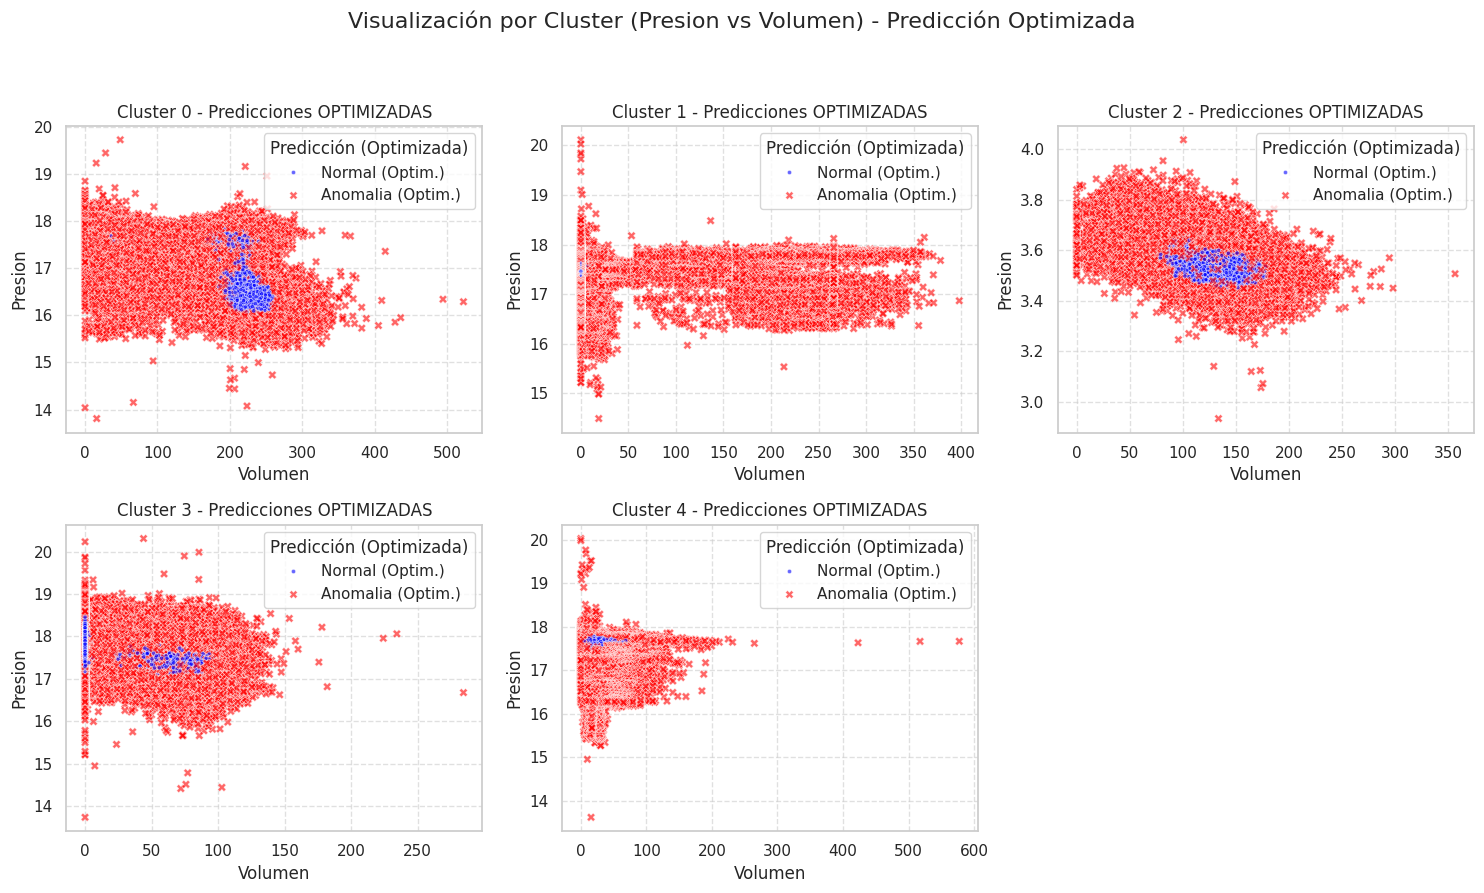

In [28]:
# =============================================================================
# --- Sección 9: Visualización por Cluster (usando Predicción OPTIMIZADA) ---
# Ahora usa la columna 'Anomalia_Predicha_Otimizada' calculada en la sección anterior
# =============================================================================
print("\n--- 8. Visualización por Cluster (con Predicción OPTIMIZADA) ---")
print(f"Generando gráficos de dispersión ({FEATURE_Y_VIZ} vs {FEATURE_X_VIZ})...")
# Verificar si clusters_treinados_com_sucesso existe
if 'clusters_treinados_com_sucesso' not in locals() or not clusters_treinados_com_sucesso: clusters_para_visualizar = []
else: clusters_para_visualizar = sorted(clusters_treinados_com_sucesso)
# Verificar datos y columna de predicción optimizada
if not clusters_para_visualizar: print("Ningún modelo entrenado encontrado para visualización.")
elif 'df_clusterizado' not in locals() or df_clusterizado is None or 'Anomalia_Predicha_Otimizada' not in df_clusterizado.columns: print("Error: df_clusterizado o columna 'Anomalia_Predicha_Otimizada' no disponible.")
else:
    print(f"Visualizando modelos para clusters: {clusters_para_visualizar}")
    n_clusters_viz = len(clusters_para_visualizar); n_cols_viz = 3 ; n_rows_viz = int(np.ceil(n_clusters_viz / n_cols_viz))
    fig_viz, axes_viz = plt.subplots(n_rows_viz, n_cols_viz, figsize=(n_cols_viz*5, n_rows_viz*4.5), squeeze=False)
    axes_viz = axes_viz.flatten(); plot_idx_viz = 0
    # Loop para Generar Gráficos
    for k in clusters_para_visualizar:
        df_k_viz = df_clusterizado[df_clusterizado['cluster'] == k]
        if df_k_viz.empty: continue
        if plot_idx_viz >= len(axes_viz): print(f"  Aviso: Más clusters ({k}) que ejes disponibles. Omitiendo gráfico."); continue
        ax_viz = axes_viz[plot_idx_viz]
        try:
            print(f"  Generando gráfico optimizado para Cluster {k}...")
            palette_viz = {0:'blue', 1:'red', -1: 'gray'}; markers_viz = {0:'.', 1:'X', -1: 's'}; labels_map_viz = {0: 'Normal (Optim.)', 1: 'Anomalia (Optim.)', -1: 'Error/Sin Thr.'}
            if FEATURE_X_VIZ not in df_k_viz.columns or FEATURE_Y_VIZ not in df_k_viz.columns: print(f"  Error Viz: Columnas '{FEATURE_X_VIZ}'/'{FEATURE_Y_VIZ}' no encontradas."); fig_viz.delaxes(ax_viz); continue

            # Verificar NaNs en las columnas de visualización antes de plotar
            if df_k_viz[[FEATURE_X_VIZ, FEATURE_Y_VIZ]].isnull().values.any():
                print(f"  Advertencia Cluster {k}: NaNs encontrados en columnas de visualización. Eliminando filas con NaNs para plotar.")
                df_k_viz = df_k_viz.dropna(subset=[FEATURE_X_VIZ, FEATURE_Y_VIZ])
                if df_k_viz.empty:
                     print(f"  Cluster {k}: Sin datos válidos para plotar después de eliminar NaNs.")
                     # No borrar eje aquí, dejar que limpieza final lo haga
                     continue


            sns.scatterplot(data=df_k_viz, x=FEATURE_X_VIZ, y=FEATURE_Y_VIZ, hue='Anomalia_Predicha_Otimizada', palette=palette_viz, style='Anomalia_Predicha_Otimizada', markers=markers_viz, alpha=0.6, ax=ax_viz, legend='full')
            ax_viz.set_title(f'Cluster {k} - Predicciones OPTIMIZADAS'); ax_viz.set_xlabel(FEATURE_X_VIZ); ax_viz.set_ylabel(FEATURE_Y_VIZ); ax_viz.grid(True, linestyle='--', alpha=0.6)
            # Ajustar leyenda
            handles, labels_str = ax_viz.get_legend_handles_labels(); actual_codes = sorted(df_k_viz['Anomalia_Predicha_Otimizada'].unique()); new_h = []; new_l = []
            if handles:
                 rev_map = {str(cd): cd for cd in labels_map_viz.keys()}
                 for h, l_str in zip(handles, labels_str):
                     code = rev_map.get(l_str, None)
                     if code is not None and code in actual_codes: new_h.append(h); new_l.append(labels_map_viz[code])
                 if new_h: ax_viz.legend(new_h, new_l, title='Predicción (Optimizada)')
                 elif ax_viz.get_legend() is not None: ax_viz.get_legend().remove()
            plot_idx_viz += 1
        except Exception as e:
            print(f"  Error al generar gráfico optimizado para cluster {k}: {e}")
            traceback.print_exc()
            # CORRECCIÓN: No borrar el eje aquí, dejar que el bucle de limpieza final lo haga
            # if plot_idx_viz < len(axes_viz): fig_viz.delaxes(axes_viz[plot_idx_viz])
    # ---- Fin del Bucle de Gráficos ----
    for i in range(plot_idx_viz, len(axes_viz)): # Eliminar ejes extra
        if i < len(axes_viz):
             try: # Añadir try/except aquí por seguridad extra
                 fig_viz.delaxes(axes_viz[i])
             except KeyError:
                 print(f"  Advertencia: Eje {i} ya eliminado o inválido durante la limpieza final.")
    if plot_idx_viz > 0:
        fig_viz.suptitle(f'Visualización por Cluster ({FEATURE_Y_VIZ} vs {FEATURE_X_VIZ}) - Predicción Optimizada', fontsize=16, y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        plt.show()
    else: print("Ningún gráfico de dispersión optimizado fue generado.")